In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm


In [2]:
all_stocks = pd.read_csv('stock_yfinance_data.csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [3]:
stock_df = all_stocks[all_stocks['Stock Name'] == "TSLA"]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

/var/folders/pk/797syh6d4477zd69bq0trp140000gn/T/ipykernel_13156/3636239815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])
/var/folders/pk/797syh6d4477zd69bq0trp140000gn/T/ipykernel_13156/3636239815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Date'] = stock_df['Date'].dt.date


In [4]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,TSLA
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,TSLA
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,TSLA
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,TSLA


In [5]:
finance_df = stock_df[['Date', 'Close']]

### Basic autocorrelation testing

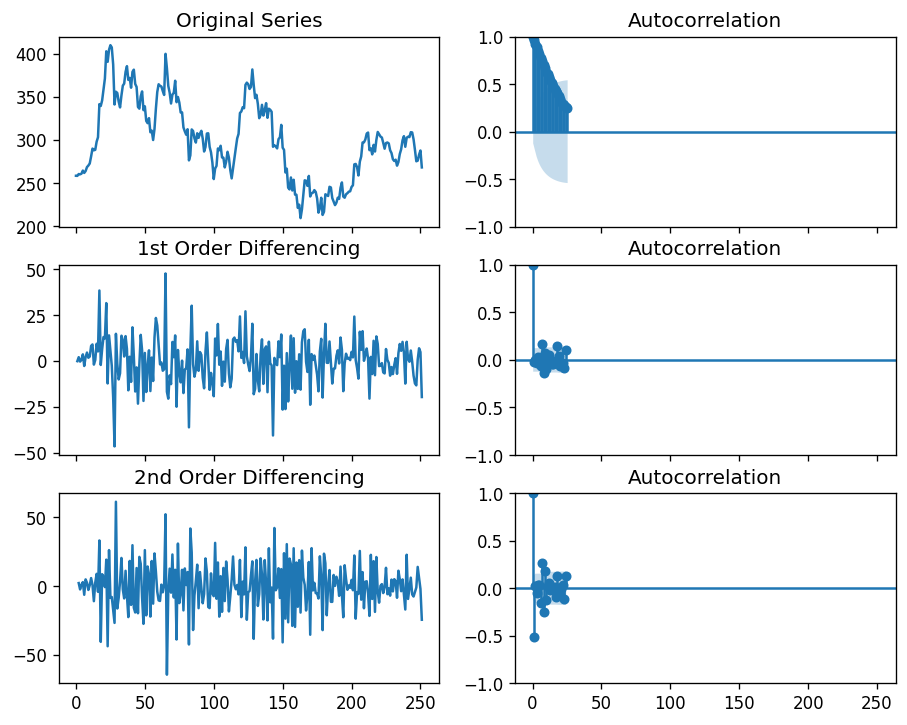

In [6]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(finance_df.Close); axes[0, 0].set_title('Original Series')
plot_acf(finance_df.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(finance_df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(finance_df.Close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(finance_df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(finance_df.Close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### auto ARIMA

In [7]:
data = pd.read_csv('stock_yfinance_data.csv', parse_dates=['Date'], index_col='Date')

In [8]:
data = data[data['Stock Name'] == "TSLA"]
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Stock Name'])

In [9]:
# Create Training and Test
train = data[:-50]
test = data[-50:]

In [10]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=50,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True, # d=0: let model decide
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[50]             : AIC=inf, Time=34.68 sec
 ARIMA(0,1,0)(0,1,0)[50]             : AIC=1296.737, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[50]             : AIC=1277.041, Time=7.15 sec
 ARIMA(0,1,1)(0,1,1)[50]             : AIC=inf, Time=13.15 sec
 ARIMA(1,1,0)(0,1,0)[50]             : AIC=1298.641, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[50]             : AIC=1276.264, Time=31.93 sec
 ARIMA(1,1,0)(2,1,1)[50]             : AIC=inf, Time=164.35 sec
 ARIMA(1,1,0)(1,1,1)[50]             : AIC=inf, Time=21.88 sec
 ARIMA(0,1,0)(2,1,0)[50]             : AIC=1274.753, Time=21.01 sec
 ARIMA(0,1,0)(1,1,0)[50]             : AIC=1275.602, Time=5.45 sec
 ARIMA(0,1,0)(2,1,1)[50]             : AIC=inf, Time=439.05 sec
 ARIMA(0,1,0)(1,1,1)[50]             : AIC=inf, Time=69.24 sec
 ARIMA(0,1,1)(2,1,0)[50]             : AIC=1276.235, Time=28.23 sec
 ARIMA(1,1,1)(2,1,0)[50]             : AIC=1278.108, Time=51.78 sec
 ARIMA(0,1,0)(2,1,0)[50] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  202
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 50)   Log Likelihood                -634.376
Date:                            Sat, 27 Apr 2024   AIC                           1274.753
Time:                                    10:21:33   BIC                           1283.804
Sample:                                         0   HQIC                          1278.430
                                            - 202                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L50      -0.5441      0.104     -5.235      0.000      -0.748      -0.340
ar.S.L100     -0.2477      0.157     -1.575      0.115      -0.556       0.061
sigma2       233.3906     29.149      8.007      0.000     176.259     290.522
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 7.81
Prob(Q):                              0.49   Prob(JB):                         0.02
Heteroskedasticity (H):               0.70   Skew:                             0.36
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


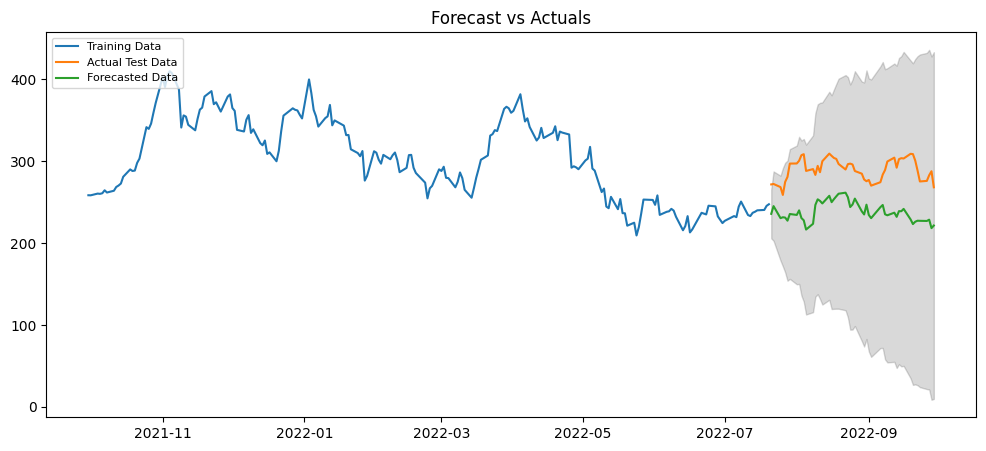

In [11]:
# Forecasting the next 50 data points
forecast_result = smodel.predict(n_periods=50, return_conf_int=True)
fc_series = pd.Series(np.array(forecast_result[0]), index=test.index)
conf_int = forecast_result[1]

# Extracting confidence intervals
lower_series = pd.Series(conf_int[:, 0], index=test.index)
upper_series = pd.Series(conf_int[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Test Data')
plt.plot(fc_series, label='Forecasted Data')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Manual Try

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWar

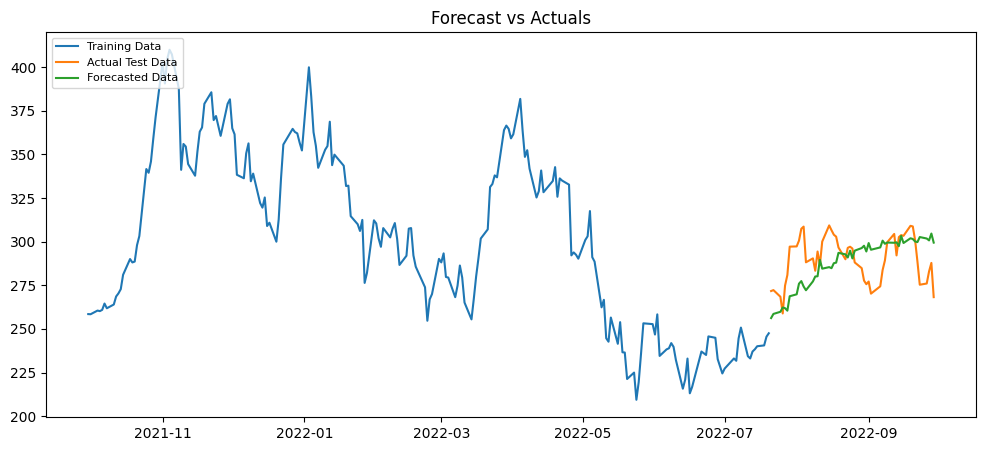

In [49]:
# Fit the ARIMA model
p, d, q = 20 ,0,11
model = ARIMA(train['Close'], order=(p,d,q))  # replace p, d, q with your chosen parameters
fitted_model = model.fit()

# Forecasting the next 50 data points
forecast_result = fitted_model.get_forecast(steps=50)

# Extract forecast and confidence intervals
fc_series = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Test Data')
plt.plot(test.index[:],fc_series, label='Forecasted Data')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import math

rmse = math.sqrt(mean_squared_error(test['Close'], fc_series))
# Calculate MAE
mae = mean_absolute_error(test['Close'], fc_series)

# Calculate MAPE
mape = mean_absolute_percentage_error(test['Close'], fc_series)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

MAE: 14.03
MAPE: 0.05%
RMSE: 16.80


In [64]:
import itertools

# Define the ranges for p, d, and q
p_values = [8]  # Range for p: 0 to 20 (inclusive)
d_values = [0] # Range for d: 0 to 20 (inclusive)
q_values = [14 ] # Range for q: 0 to 20 (inclusive)

# Initialize variables to store the best parameter values and the corresponding evaluation metric
best_rmse = float('inf')  # Initialize with a high value
best_p, best_d, best_q = None, None, None

# Perform grid search
for p, d, q in itertools.product(p_values, d_values, q_values):
    # Fit the ARIMA model
    model = ARIMA(train['Close'], order=(p, d, q))
    fitted_model = model.fit()

    # Forecast the next data points
    forecast_result = fitted_model.get_forecast(steps=len(test))

    # Extract the forecasted series
    fc_series = forecast_result.predicted_mean

    # Calculate the evaluation metric (RMSE)
    rmse = math.sqrt(mean_squared_error(test['Close'], fc_series))

    # Check if current parameters result in a better RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_p, best_d, best_q = p, d, q

# Print the best parameter values and the corresponding RMSE
print("Best Parameters:")
print(f"p = {best_p}, d = {best_d}, q = {best_q}")
print(f"RMSE: {best_rmse:.2f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Best Parameters:
p = 8, d = 0, q = 14
RMSE: 18.43


In [65]:
print("Best Parameters:")
print(f"p = {best_p}, d = {best_d}, q = {best_q}")
print(f"RMSE: {best_rmse:.2f}")

Best Parameters:
p = 8, d = 0, q = 14
RMSE: 18.43


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

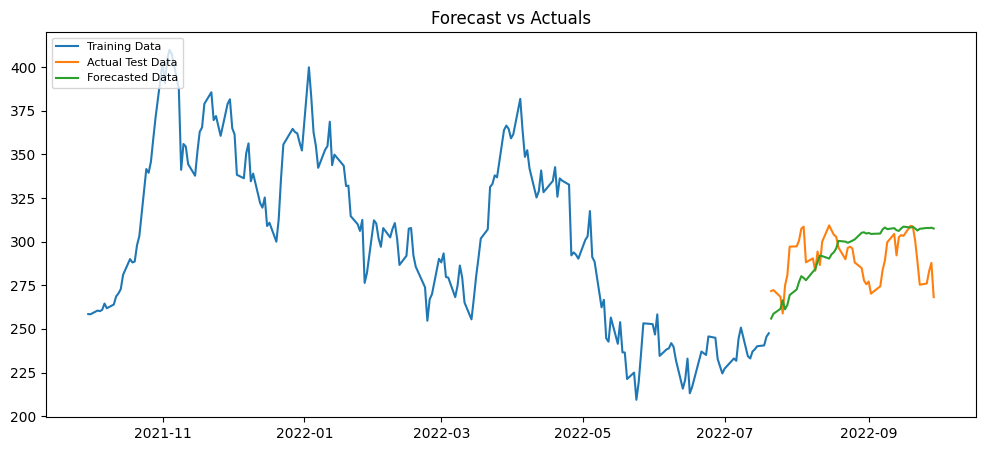

In [66]:
# Fit the ARIMA model
p, d, q = 8,0,14
model = ARIMA(train['Close'], order=(p,d,q))  # replace p, d, q with your chosen parameters
fitted_model = model.fit()

# Forecasting the next 50 data points
forecast_result = fitted_model.get_forecast(steps=50)

# Extract forecast and confidence intervals
fc_series = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Test Data')
plt.plot(test.index[:],fc_series, label='Forecasted Data')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()